# Rozpoznawanie emocji w krótkich tekstach z użyciem LSTM

### Dataset: 
dair-ai/emotion - https://huggingface.co/datasets/dair-ai/emotion

### Cel:
Opracowanie modelu głębokiego uczenia, który potrafi automatycznie rozpoznawać emocje wyrażone w krótkich tekstach. 
Zadanie należy do kategorii klasyfikacji tekstu NLP i wymaga uchwycenia kontekstu oraz zależności między słowami. 
Dane: zbiór danych Emotions z biblioteki HuggingFace Datasets (joy, sadness, anger, fear, love, surprise)

### Plan: 
1. Przygotowanie danych i pobranie ich 
2. Tokenizacja, padding 
3. Prosty model LSTM 
4. Trening modelu 
5. Macierz błędów 
6. Wykresy, matplotlib 
7. Testowanie Plan 
8. (dodatkowe opcje rozszerzenia): Interfejs graficzny, gradio

### Przygotowanie środowiska
Przed rozpoczęciem zadania musieliśmy przygotować środowisko.

In [9]:
#!pip install datasets tensorflow seaborn gradio

### Importy
Wszystkie niezbędne metody i funkcje importujemy na samym początku.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

### 1. Pobieranie danych
Dane pobieramy z HuggingFace. Następnie zamieniamy je w ramkę Pandas i dzielimy zbiór na testowy i treningowy. Mamy 16000 przykładów do treningu i 2000 do testu.

In [11]:
dataset = load_dataset("dair-ai/emotion")

df = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

texts = df['text'].values
labels = df['label'].values

# Mapowanie etykiet
label_names = dataset['train'].features['label'].names

print("Wielkość datasetu treningowego:", len(df))
train_counts = Counter(df['label'])
for k, v in train_counts.items():
    print(f"{label_names[k]}: {v}")

print("\nWielkość datasetu testowego:", len(df_test))
test_counts = Counter(df_test['label'])
for k, v in test_counts.items():
    print(f"{label_names[k]}: {v}")

print("\nPrzykładowe dane treningowe:")
for i in range(3):
    print(f"Wiersz numer {i+1}: {texts[i]} ---> {label_names[labels[i]]}")

Wielkość datasetu treningowego: 16000
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

Wielkość datasetu testowego: 2000
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

Przykładowe dane treningowe:
Wiersz numer 1: i didnt feel humiliated ---> sadness
Wiersz numer 2: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake ---> sadness
Wiersz numer 3: im grabbing a minute to post i feel greedy wrong ---> anger


### 2. Tokenizacja i padding
Sieci neuronowe nie rozumieją tekstu. Model LSTM przyjmuje liczby o stałym rozmiarze dlatego zmieniamy tekst na reprezentację numeryczną o jednakowej długości. Tokenizujemy słowa na sekwencję tokenów. Np. "I am very happy" -> [12, 7, 45, 203]. Każda liczba reprezentuje konkretne słowo. Aby to osiągnąć określamy wielkość słownika, czyli unikatówych słów. Wybierane zostaną te, które pojawiają się najczęściej a reszta będzie ignorowana. Następnie określamy też OOV - Out Of Vocabulary, wszystkie nieznane słowa trafią do jednego tokenu (OOV) a model nauczy sobie radzić z nowymi słowami. Bez tego przy nieznanym słowie nie miałby żadnych informacji.

Dalej wykonujemy fit_on_texts(texts) gdzie texts to są wszystkie teksty ze zbioru treningowego. Analizuje on nasz zbiór, buduje słownik (słowo -> indeks) a indeksy zależą od częstotliwości wystąpień. Najczęstsze słowo ma najmniejszy indeks. Na koniec zamieniamy tekst na sekwencje. Każde zdanie jest na zamieniane na listę liczb gdzie długości sekwencji są różne ("I am very happy" -> [12, 7, 45, 203], "I am happy" -> [12, 7, 203])

Skoro wiemy, że model oczekuje wejść jednakowej długości a nasze sekwencje zdań mogą mieć różne długości musimy wprowadzić padding aby je wyrównać. Padding krótsze sekwencje będzie uzupełniał zerami a dłuższe ucinał. Ustawiliśmy maksymalną długość paddingu na 50, ponieważ większość zdań ma mniej niż 40 słów. Gdybyśmy ustawili na 5 nasze poprzednie przykłady wyglądały by nastepująco: "I am very happy" -> [12, 7, 45, 203, 0], "I am happy" -> [12, 7, 203, 0, 0]. Ustawiamy wartość post aby dawać zera na końcu a nie na początku sekwencji.

Na koniec dzielimy zbiór treningowy na 80% treningu i 20% walidacji. Dzięki temu model sam będzie walidował swoją skuteczność. Ostatecznie mamy podział danych:  12800 zbiór treningowy, 3200 zbiór walidacyjny, 2000 zbiór testowy.

In [12]:
vocab_size = 20000 # Liczba unikalnych słów w słowniku. Za mała -> utrata informacji, za duża -> overfitting i wolniejszy trening
max_len = 50 # Maksymalna długość sekwencji. Za mała -> obcięcie kontekstu, za duża -> dużo zer w paddingu

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Dane testowe
X_test_seq = tokenizer.texts_to_sequences(df_test['text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
y_test = df_test['label'].values

# Podział train / validation
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

Poniżej z ciekawości wypisaliśmy top 10 najczęściej występujących słów w słowniku, czyli indeksy od 1-10.

In [13]:
top_n = 10

sorted_words = sorted(
    tokenizer.word_index.items(),
    key=lambda x: x[1]
)

print(f"Top {top_n} najczęstszych słów:")
for word, idx in sorted_words[:top_n]:
    print(f"{idx}. {word}")

Top 10 najczęstszych słów:
1. <OOV>
2. i
3. feel
4. and
5. to
6. the
7. a
8. feeling
9. that
10. of


### 3. Model LSTM
Przygotowywujemy model do treningu. Wykorzystamy Sequential ponieważ model jest liniowy, nie posiada rozgałęzień, jest idealny dla klasyfikacji tekstu.

Embedding zamienimy indeks słowa na wektor liczby a każdy wektor reprezentować będzie znaczenie słowa. Np. "happy" -> [0.12, -0.34, 0.87, ...]. Dzięki temu podobne słowa będą miały podobne wektory i na podstawie tego model będzie uczył się semantyki emocji.

Warstwa LSTM będzie przetwarzać sekwencje słów krok po kroku, zapamiętywać istotne informacje i zapominać nieistotne. Bidirectional LSTM sprawi, że model czyta zdanie od początku do końca oraz od końca do początku. Korzystamy z tego ponieważ emocja może zależeć od końcówki zdania, np. „I thought it would be bad, but I loved it”.

Dropout losowo "wyłącza" część neuronów co epokę, dzięki czemu powinno to zapobiegać przeuczeniu.

Warstwa Dense (ukryta) łączy cechy wekstrahowane przez LSTM i tworzy bardziej abstrakcyjną reprezentację emocji.

Warstwa wyjściowa zwraca rozkład prawdopodobieństwa, po jednym dla każdej emocji. Np. 
- joy: 0.72
- sadness: 0.10
- anger: 0.05

In [14]:
adam_learning_rate = 0.001

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=False)), # Liczba komórek pamięci LSTM. Za mała -> model nie nauczy się wzorców, za duża -> overfitting i wolniejszy trening
    Dropout(0.5), # Regularyzacja - losowe wyłączanie neuronów podczas treningu, zapobiega przeuczaniu jednak może wydłużyć czas treningu przy zbyt dużej wartości
    Dense(64, activation='relu'), # Warstwa gęsta z 64 neuronami i funkcją aktywacji ReLU
    Dense(len(label_names), activation='softmax') # Warstwa wyjściowa z liczbą neuronów równą liczbie klas i funkcją aktywacji softmax
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=adam_learning_rate),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 4. Trening modelu
Celem treningu jest znalezienie takich wag, które minimalizują błąd predykcji emocji. Wcześniej podczas tworzenia modelu ustaliliśmy funkcję straty jako sparse_categorical_crossentropy, ponieważ mamy wiele klas, etykeity są liczbami (0-5) a softmax + crsoss-entropy to standard.

Jako optimizer używamy Adam, łączy on zalety SGD i RMSProp, jest stabilny i posiada szybką konwergencję.

Batch size, czyli ilość próbek, ustawiamy na 64 w celu przyśpieszenia treningu.

Epoki, czyli jedno przejście przez cały zbiór treningowy, ustawiamy na 20. Najprawdodpodobniej model nie przejdzie aż tyle epok przez EarlyStopping, który opiszemy później.

Zbiór walidacyjny to nasze 3200 próbek ze zbioru treningowego.

Early stopping zatrzymuje trening przy overfittingu. Oszczędza to czas i poprawia generalizację.

Ustalamy wagi klas, przez to, że dataset jest mocno niezbalansowany. Dzięki temu, błąd na rzadkich klasach jest "droższy" a model nie faworyzuje "joy".

In [15]:
# Wakowanie kategorii ze względu na niezbalansowane dane. Musieliśmy to dodać bo model faworyzował klasy z większą liczbą próbek, w naszym wypadku wszystkim tekstom nadawał kategorię joy.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Wagi klas:", class_weights)

Wagi klas: {0: np.float64(0.5734767025089605), 1: np.float64(0.49143822467941334), 2: np.float64(2.1164021164021163), 3: np.float64(1.2317167051578137), 4: np.float64(1.3852813852813852), 5: np.float64(4.647785039941903)}


Przygotowywujemy tą metodę tylko i wyłącznie po to, aby monitorować "learning rate" a na koniec stworzyć z niego wykres.

In [16]:
def lr_schedule(epoch, lr):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',  # obserwujemy jakość na zbiorze walidacyjnym
    patience=3, # czekamy X kolejne eopok bez poprawy 
    restore_best_weights=True # wracamy do najlepszego modelu a nie ostatniego
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),

    epochs=10, # Maksymalna liczba epok treningowych, czyli przejść przez dane treningowe
    batch_size=64, # Liczba próbek przetwarzanych jednocześnie, mniejszy -> dokładniejszy, większy -> szybszy trening
    class_weight=class_weights,

    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.2236 - loss: 1.6701 - val_accuracy: 0.6078 - val_loss: 1.0402 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7977 - loss: 0.5800 - val_accuracy: 0.8791 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9250 - loss: 0.2211 - val_accuracy: 0.8800 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9501 - loss: 0.1356 - val_accuracy: 0.8944 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9627 - loss: 0.1030 - val_accuracy: 0.8900 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9795 - loss: 0.0595 - val_accuracy: 0.8906 - val_loss: 0.4161 - learning_rate: 5.0000e-04
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9855 - loss

### 5. Macierz błędów
Tabela pokazująca rzeczywiste klasy (wiersze) oraz przewidziane klasy (kolumny). Każda komórka zawiera liczbę przykładów, gdzie wierwsz to prawdziwa kategoria a kolumna to kategoria przewidziana przez model.

Idealna macierz to taka, gdzie wartości są tylko na przekątnej i brakuje ich poza nią. Możemy z niej wyczytać, które emocje są rozpoznawane najlepiej, które są mylone, czy model faworyzuje jedną klasę i wpływ niezbalansowanych danych.

Z naszej macierzy błędów wynika, że model całkiem nieźle radzi sobie z klasyfikacją i nie robi aż tak wielu błędów. Warto zauważyć, że model najczęściej mylił kategorię między "joy" a "love".

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


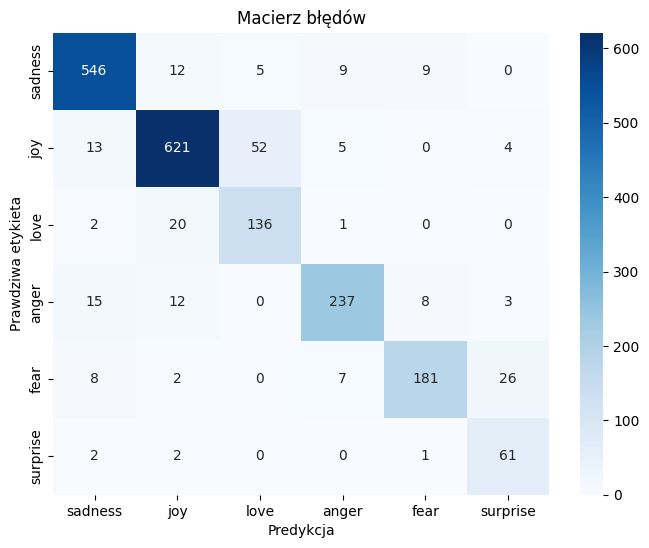

              precision    recall  f1-score   support

     sadness       0.93      0.94      0.94       581
         joy       0.93      0.89      0.91       695
        love       0.70      0.86      0.77       159
       anger       0.92      0.86      0.89       275
        fear       0.91      0.81      0.86       224
    surprise       0.65      0.92      0.76        66

    accuracy                           0.89      2000
   macro avg       0.84      0.88      0.85      2000
weighted avg       0.90      0.89      0.89      2000



In [18]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa etykieta")
plt.title("Macierz błędów")
plt.show()

print(classification_report(y_test, y_pred, target_names=label_names))

### 6. Wykresy treningu
#### Dokładność
Dokładność pokazuje jak dobrze model radzi sobie z przewidywaniem poprawnej kategorii.

Dobra sytuacja to taka, w której obie krzywe rosną i są blisko siebie. Overfitting następuje kiedy treningowa krzywa rośnie a walidacyjna spada lub stoi. Underfitting pojawia się kiedy obie są nisko i nie następuje poprawa.

Z naszych danych możemy zauważyć, że krzywa treningowa rośnie a walidacyjna zatrzymała się a nawet zaczęła powoli spadać, oznacza to, że możemy już mieć doczynienia z przeuczeniem modelu.

#### Strata
Strata mierzy jak bardzo model się myli oraz uwzględnia pewność predykcji. Dla klasyfikacji używamy cross-entropy.

Idealna sytuacja to taka, w której krzywa treningowa i walidacyjna spada. Overfitting następuje kiedy krzywa treningowa spada a walidacyjna rośnie. Underfitting pojawa się kiedy obie są wysokie.

W naszym wykresie możemy zauważyć, że model jest już przetrenowany bo krzywa walidacyjna mocno rośnie, kiedy treningowa spada.

#### Learning Rate
Learning Rate określa jak duży krok wykonuje algorytm optymalizacji podczas aktualizacji wag. Na wykrresie możemy też sprawdzić działanie schedulera, upewnić się, że LR maleje i diagnozować niestabilny trening.

Poprawny przebieg to taki, w którym learning rate maleje a zmiany są skokowe lub płynne. Zbyd duży learning rate jest wtedy, kiedy loss oscyluje lub nie ma zależności. Zbyt mały kiedy poprawa jest badzo wolna albo trening jest długi.


Z naszego wykresu możemy zauważyć, że val_loss nie zmniejszał się przez określoną liczbę epok (patience), następnie scheduler zareagował a learning rate został zmniejszony o połowe. To mechanizm automatycznej stabilizacji treningu. Zmniejszony learning rate pozwala wykonywać mniejsze, precyzyjniejsze kroki, pozwala na dostrajanie (fine-tuning) wag i redukuj ryzyko oscylacji wokół minimum. Na koniec trening zakończył się po 6 epoce w efekcie EarlyStoipping, który definiowaliśmy wcześniej.

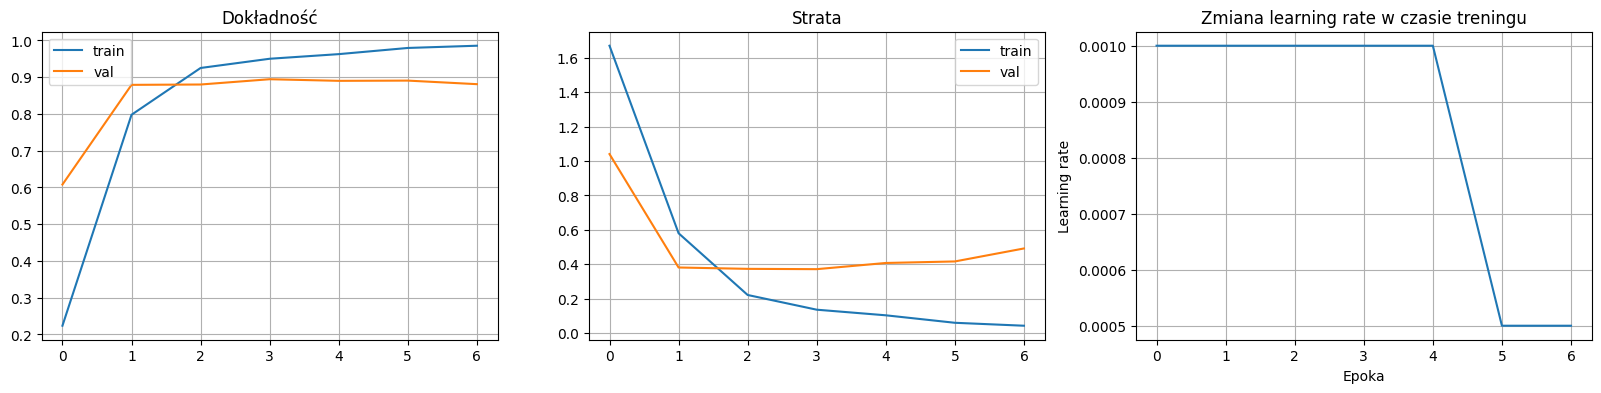

In [37]:
plt.figure(figsize=(12,4)).set_figwidth(20)

plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Dokładność')
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Strata')
plt.grid(True)
plt.legend()

lrs = history.history['learning_rate']
plt.subplot(1,3,3)
plt.plot(lrs)
plt.xlabel("Epoka")
plt.ylabel("Learning rate")
plt.title("Zmiana learning rate w czasie treningu")
plt.grid(True)

plt.show()

Pod spodem konkretne liczby straty i dokładności jakie osiągnął model na danych testowych.

In [41]:
test_loss, test_accuracy = model.evaluate(
    X_test_pad,
    y_test,
    batch_size=64,
    verbose=1
)

print(f"Test straty: {test_loss:.4f}")
print(f"Test dokładności: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8910 - loss: 0.3545
Test straty: 0.3545
Test dokładności: 0.8910


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


### 7. Testowanie na własnym przykładzie

In [21]:
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)
    label_id = np.argmax(pred)
    return label_names[label_id]

example = "I feel like heaven today."
print("Tekst:", example)
print("Rozpoznana emocja:", predict_emotion(example))

Tekst: I feel like heaven today.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Rozpoznana emocja: sadness


### 8. Interfejs
Za pomocą Gradio zbudowaliśmy prosty interfejs graficzny, za pomocą którego można w łatwy sposób testować swoje przykłady.

Teksty powinny być wprowadzane w języku angielskim, ze względnu na dane, na których model był uczony.

In [ ]:
import gradio as gr

def gradio_predict(text):
    return predict_emotion(text)

iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=2, placeholder="Wpisz tekst..."),
    outputs="label",
    title="Rozpoznawanie emocji (LSTM)"
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
